### Detector Systematics 
- Load the DetVar samples, applies the nue selection on them
- The after selection pickl is used to study the variations

-- efficieny at different stages

-- in function of a variable (plot)

In [21]:
import nue_selection_helper as nue_helper
from helpers import helpfunction as helper
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
data = pd.read_pickle('./input/July2020/lite/after_training.pckl')

In [3]:
data = data['nu']

In [17]:
values = data['daughters'].xs(0, level='daughter')['shr_energy_y_v']
cv_weights = data['daughters'].xs(0, level='daughter')['weightSplineTimesTune']
flux_weights = data['mc']['weightsFlux']
assert(len(flux_weights) == len(cv_weights))
x_min = 0
x_max = 2000
n_bins = 20

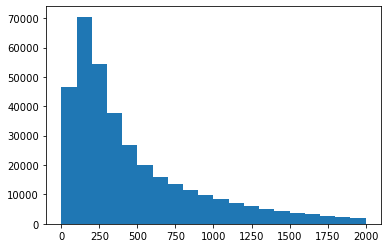

In [20]:
_ = plt.hist(values, range=(x_min,x_max), bins=n_bins, weights=cv_weights)

In [79]:
def cov_nonvec(values, cv_weights, weights, x_min, x_max, n_bins):
    start = time.time()
    n_cv, bin_edges = np.histogram(values, weights=cv_weights, range=(x_min,x_max), bins=n_bins)
    n_uni = flux_weights.shape[1]
    cov_this = np.zeros([n_bins, n_bins])
    print(bin_edges)
    print(n_cv)

    n_uni=1000

    weights = np.multiply(weights,cv_weights[:, np.newaxis])
    for i in range(n_uni):
        n, _ = np.histogram(values, weights=weights.T[i], bins=bin_edges,)
        cov_this += np.outer(n - n_cv, n - n_cv)

    end = time.time()
    print("mean fractional error", np.mean(np.sqrt(np.diag(cov_this / n_uni)) / n_cv))
    print('time passed: {:.1f}s.'.format(end-start))

In [83]:
def cov_halfvec(values, cv_weights, weights, x_min, x_max, n_bins):
    start = time.time()
    n_cv, bin_edges = np.histogram(values, weights=cv_weights, range=(x_min,x_max), bins=n_bins)
    binning = np.digitize(values, bin_edges)-1
    weights = np.multiply(weights,cv_weights[:, np.newaxis])
    n_uni = flux_weights.shape[1]
    n = np.empty((n_bins, n_uni))
    cov_this = np.zeros([n_bins, n_bins])
    for i in range(n_bins):
        n[i] = np.sum(np.multiply(weights,np.array(binning==i)[:, np.newaxis]),axis=0)
    for k in range(n_uni):
        cov_this += np.outer(n.T[k] - n_cv, n.T[k] - n_cv)

    end = time.time()
    print("mean fractional error", np.mean(np.sqrt(np.diag(cov_this / n_uni)) / n_cv))
    print('time passed: {:.1f}s.'.format(end-start))

cov_halfvec(values, cv_weights, flux_weights, x_min, x_max, n_bins)

mean fractional error 0.07039424616464579
time passed: 23.6s.


In [80]:
cov_nonvec(values, cv_weights, flux_weights, x_min, x_max, n_bins)

[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000.]
[46393.93   70478.414  54361.477  37830.555  26762.488  20047.285
 16085.182  13591.455  11400.237   9809.034   8362.731   7033.9575
  5917.467   5122.519   4287.8525  3687.361   3166.562   2727.0952
  2336.233   1969.5887]
mean fractional error 0.07039380681435112
time passed: 42.0s.


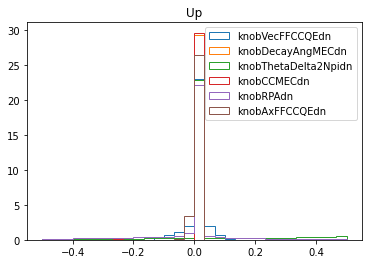

In [8]:
for k in knobs:
    up_weights = np.clip(np.nan_to_num(data['mc'][k], nan=1, posinf=1, neginf=1),0,20)
    up_weights = np.where(up_weights!=0, up_weights, 1)
    k = k.replace('up','dn')
    down_weights = np.clip(np.nan_to_num(data['mc'][k], nan=1, posinf=1, neginf=1),0,20)
    down_weights = np.where(down_weights!=0, down_weights, 1)
    plt.hist(up_weights-down_weights, range=(-0.5,0.5), bins=30, density=1, label=k, histtype='step')
plt.legend()
plt.title('Up')
plt.show()

In [5]:
write_pickle = False
outfile = './input/Jun2020/lite/sys_after_training.pckl'
input_dir = "./input/Jun2020/syst/"
output_dir = "./output/"

In [3]:
samples = ['_'.join(f.split('/')[-1].split('.')[0].split('_')[:-1]) for f in glob.glob(input_dir+'*.pckl')]

In [4]:
if write_pickle:
    nue_helper.CreateAfterTraining(samples, input_dir, one_file=outfile)
data = pd.read_pickle(outfile)

In [5]:
data.keys()

dict_keys(['nue_DetVar_WireModAngleYZ', 'nue_DetVar_LYRayleigh', 'nue_DetVar_LYAttenuation', 'nue_DetVar_wiremod_ScaleYZ', 'nue_DetVar_LYDown', 'nue_DetVar_wiremod_ScaledEdX', 'nue_DetVar_WireModAngleXZ', 'nue_DetVar_CV', 'nue_DetVar_wiremod_ScaleX'])

In [6]:
# We grouped by 'event' was this a smart choice?
for sample in samples:
    assert len(np.unique(data[sample]['daughters'].xs(0, level='daughter').index)) == len(data[sample]['daughters'].xs(0, level='daughter').index)

In [27]:
for sample in samples:
    data[sample]['daughters']['nueccinc_new'] = data[sample]['daughters']['category'].isin([1,10,11])
    num_w = data[sample]['daughters'].eval('nueccinc*weightSplineTimesTune').xs(0, level='daughter')
    den_w = data[sample]['mc']['weightSplineTimesTune'][data[sample]['mc']['nueccinc']]
    print('{:<30}\t Efficiency: {:0.1%}+-{:0.1%}'.format(sample, *helper.effErr(num_w, den_w) ))

nue_DetVar_WireModAngleYZ     	 Efficiency: 84.2%+-0.2%
nue_DetVar_LYRayleigh         	 Efficiency: 84.1%+-0.2%
nue_DetVar_LYAttenuation      	 Efficiency: 83.8%+-0.2%
nue_DetVar_wiremod_ScaleYZ    	 Efficiency: 83.8%+-0.2%
nue_DetVar_LYDown             	 Efficiency: 84.6%+-0.2%
nue_DetVar_wiremod_ScaledEdX  	 Efficiency: 83.6%+-0.2%
nue_DetVar_WireModAngleXZ     	 Efficiency: 84.0%+-0.2%
nue_DetVar_CV                 	 Efficiency: 84.1%+-0.2%
nue_DetVar_wiremod_ScaleX     	 Efficiency: 83.8%+-0.2%
